# Modélisation et Traitement d'Images 

---

## Analytical Image Super Resolution - Zhao _et al_. 2016

---

#### Code written by Amaury Faure, Solène Gardies, Nathalie Germani, Amélie Gombeaud 
Ecole Centrale de Lille 2020-2021

**Keywords**: Scientific article analysis, Bibliographical Methodology, Programming

**Article**: The code shown below was written after reading the following article : "Fast Single Image Super-Resolution Using a New Analytical Solution for l2–l2 Problems.". For more information towards our approach, please have a look at our report.



In [1]:
#Some imports :
import numpy as np
import scipy as sc
from PIL import Image
import matplotlib.pyplot as plt
import math
import timeit
import itertools
import pandas as pd

In [2]:
%run utils/f_special.py
%run utils/HXconv.py
%run utils/INVLS.py
%run utils/create_imageLR.py
%run utils/create_filtering_matrix.py
%run utils/create_SH_y_matrix.py

%run algos/L2_SR.py
%run algos/direct_ADMM.py
%run algos/FSR_ADMM.py


## Initialisation functions : 

In this section, we define useful functions to transform the high-resolution image into a low-resolution one, and start creating some of the parameters that will be needed in the following algorithms.
We also create a function to plot the results.

In [3]:
def init_params(imageHR, muArray):
    """Function to initialize parameters.

    This functions allows to initialize usefull parameters for the ADMM method (FSR or not)

    Args:
        imageHR: the original image
        muArray: Several values for the regularization in the ADMM framework 

    Returns: 
        image_args: The following as a list: 
            imageLR_resized: Bicubic interpolation of the LR image
            imageLR: Blurred and down-sampled image
        init_args: The following as a list: 
            muSet: The arra of mu values
            tau: Constant used in analytical solution
            dr: number of discarded rows, the down sampling factor
            dc: number of discarded columns, the down sampling factor
            N: the size of the HR image
            maxiter: The maximum number of iteration in the ADMM method
            objective: ADMM stopping criteria
        H_args: The following as a list: 
            H_F: Fourier transform of the blurring kernel
            H_Fconj : It's conjugate
            H_Fcarre : It's term-wise square
        Dh_Dv_args: The following as a list: 
            Dh_F: Fourier transform of the horizontal derivation matrix
            Dh_Fconj: It's conjugate
            Dh_Fcarre: It's term-wise square
            Dv_F: Fourier transform of the vertical derivation matrix
            dv_Fconj: It's conjugate
            Dv_Fcarre: It's term-wise square
        SH_y_args: The following as a list: 
            Sh_y: The upsampled image.
            ind1_SH_y: The indices where we lost the information compared to the interpolation.
            ind2_SH_y: The indices where we know the information.
        FSR_args: The following as a list :
            d:The down-sampling factor
            nr: the vertical dimension of LR image
            nc: the horizontal dimension of HR image
            m: the size of the LR image
            Dh_Dv_regularisation: Regularization matrix.
    """
    # init_variables
    down_sampling_factor = 4
    dr = down_sampling_factor # number of discarded rows
    dc = down_sampling_factor # number of discarded columns
    
    BSNRdb = 40
    tau_p = 1e-2
    maxiter = 800
    c = 1e-8
    muSet = muArray

    # create LR image
    imageLR_resized, imageLR, nr_up, nc_up, sigma_carre, H_args, FSR_args = create_imageLR(imageHR, BSNRdb, down_sampling_factor)
    H_F, H_Fconj, H_Fcarre = H_args
    d, nr, nc, m, N = FSR_args

    nt = len(muSet)
    tau  = tau_p*sigma_carre

    # create Dh and Dv matrix
    Dh_F, Dh_Fconj, Dh_Fcarre, Dv_F, Dv_Fconj, Dv_Fcarre, Dh_Dv_regularisation = create_filtering_matrix(nr_up, nc_up, c)

    # create SH_y and the indexes that indicates which places where choosen in the down_sampling operation
    SH_y, ind1_SH_y, ind2_SH_y = create_SH_y_matrix(imageLR, nr_up, nc_up, down_sampling_factor)

    # calculate objective matrix
    # calculate resid for objective matrix
    imageLR_F = np.fft.fft2(imageLR_resized)
    imageLR_F_modified = np.fft.ifft2(H_F * np.fft.fft2(imageLR_F))
    resid =  imageLR - imageLR_F_modified[::dr,::dc]
    
    # calculate objective matrix
    objective = np.zeros((nt,maxiter))
    TVpenalty = np.sum(np.sum(np.sqrt(np.abs(np.fft.ifft2(Dh_F * imageLR_F))**2 + np.abs(np.fft.ifft2(Dv_F * imageLR_F)))**2))
    prev_f = 0.5*(resid.flatten('F').T@resid.flatten('F')) + tau_p*TVpenalty
    objective[:,0] = np.real(prev_f) # real added

    # send necessary args
    images_args = [imageLR_resized, imageLR] # images
    init_args = [muSet, tau, dr, dc, N, maxiter, objective] # constants
    H_args = [H_F, H_Fconj, H_Fcarre] # blurring matrix
    Dh_Dv_args = [Dh_F, Dh_Fconj, Dh_Fcarre, Dv_F, Dv_Fconj, Dv_Fcarre] # derivation matrix
    SH_y_args = [SH_y, ind1_SH_y, ind2_SH_y] # SH_y matrix and indexes
    FSR_args = [d, nr, nc, m, Dh_Dv_regularisation] # args for FSR-ADMM

    return images_args, init_args, H_args, Dh_Dv_args, SH_y_args, FSR_args


In [4]:
def plot_images(X, imageHR, imageLR_resized, imageLR, title):
    """ A function to plot the images in a 2*2 grid.

    This function allows to compare the original image, the degraded image, it's bicubic interpolation and the estimated image in a 2*2 grid.

    Args:
        X: Estimated image by an algorithm
        imageHR: The original image
        imageLR_resized: The LR image interpolated in the original dimension
        imageLR: The degraded image.
        title: An information to give to the title for the estimated image
    """
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(imageHR, cmap='gray')
    plt.title('Image initiale HR')

    plt.subplot(2, 2, 2)
    plt.imshow(imageLR, cmap='gray')
    plt.title('Image modifiée LR')

    plt.subplot(2, 2, 3)
    plt.imshow(imageLR_resized, cmap='gray')
    plt.title('Image modifiée LR avec interpolation Bicubique')

    plt.subplot(2, 2, 4)
    plt.imshow(np.real(X), cmap='gray')
    full_title = 'Image reconstituée : ' + title
    
    #Save Image
    new_image = Image.fromarray(np.real(X)).convert("L")
    image_title = 'images/lena_' + title.replace(' ', '_') + '.png'
    new_image = new_image.save(image_title)
    
    plt.title(full_title)

## Observing the degraded images : 

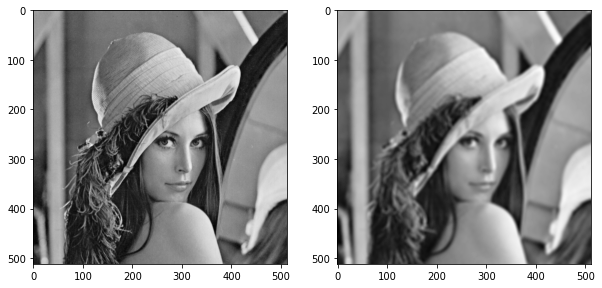

In [5]:
# Check action of fspecial (blurring operation)

import scipy.ndimage
image = plt.imread('images/lena.bmp')
B = fspecial_python(shape=(9, 9), sigma=3)
filtered_image = scipy.ndimage.correlate(image, B, mode='nearest')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.show()

Size of the initial image: (512, 512)
Size of the blurried and down-sampled image: (128, 128)
Size of the 'resized' image (with bicubic interpolation): (512, 512)


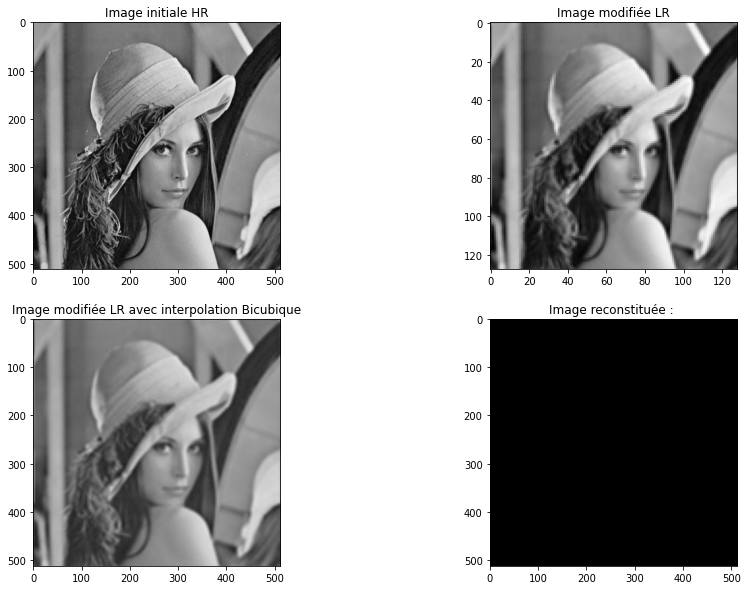

In [6]:
# Check transformation of LR image

imageHR = plt.imread('images/lena.bmp')
images_args, *_ = init_params(imageHR, [0.05])
imageLR_resized, imageLR = images_args
plot_images(np.zeros((512, 512)), imageHR, imageLR_resized, imageLR, '')
print("Size of the initial image:", np.array(imageHR).shape)
print("Size of the blurried and down-sampled image:", np.array(imageLR).shape)
print("Size of the 'resized' image (with bicubic interpolation):", np.array(imageLR_resized).shape)

## First algorithm : L2 Fast Super Resolution : 

In this part, we will use the algorithm only once to show it's capabilities. 
We will take our High-Resolution original image, then get it to a lower resolution according to the model. Lastly we will use the L2 Super-Resolution algorithm to get the SR image.

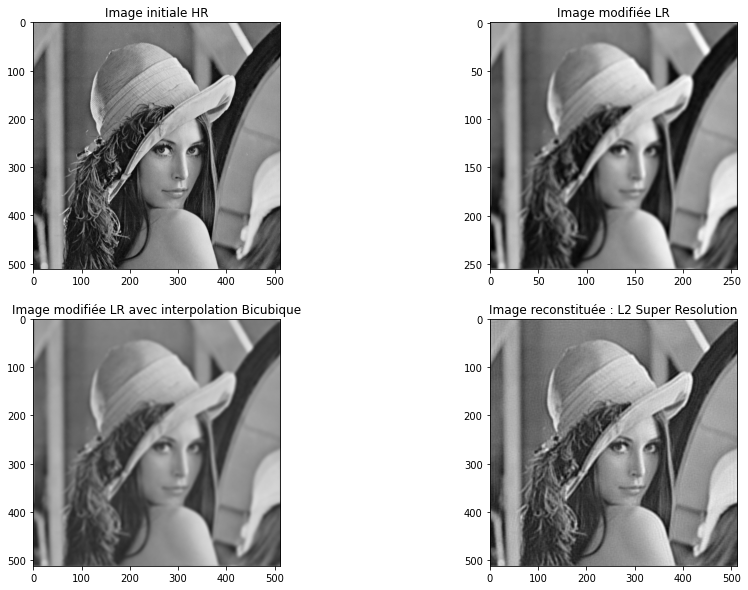

In [7]:
imageHR = plt.imread('images/lena.bmp')
L2_image, imageLR_resized, imageLR = L2_SR(imageHR)
plot_images(L2_image,imageHR,imageLR_resized ,imageLR, "L2 Super Resolution")

In [8]:
%%time
L2_image, imageLR_resized, imageLR = L2_SR(imageHR)

CPU times: user 179 ms, sys: 114 ms, total: 293 ms
Wall time: 198 ms


## Second Algorithm : Direct ADMM

The ADDM method (Alternating Direction Method of Multipliers) is a method commonly used for Super Resolution problems. 
We will implement it to illustrate how usefull the FSR algorithm can be usefull.

direct ADMM: mu =  0.05 , Iter =  47 , RMSE =  4593.064251213608 , PSNR =  -25.41385318844551 , ISNR =  3.6841137969801718e-06
Initialisation time 0.039821101003326476
Execution time of direct_ADMM -0.029278331086970866


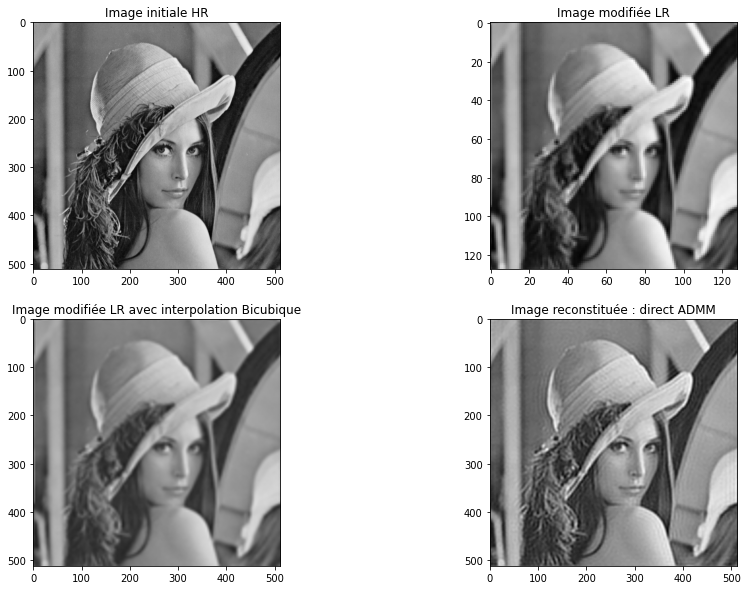

In [9]:
imageHR = plt.imread('images/lena.bmp')

tolA = 1e-3
muSet = [0.05]
t0 = timeit.timeit()
images_args, init_args, H_args, Dh_Dv_args, SH_y_args, _ = init_params(imageHR, muSet)
imageLR_resized, imageLR = images_args
t1 = timeit.timeit()
direct_image, _, _, _, _ = direct_ADMM(imageHR, imageLR_resized, imageLR, tolA, init_args, H_args, Dh_Dv_args, SH_y_args)
t2 = timeit.timeit()
plot_images(direct_image, imageHR, imageLR_resized, imageLR, 'direct ADMM')
direct_unique_time = t2-t1
print("Initialisation time", t1-t0)
print("Execution time of direct_ADMM", t2-t1)

In [10]:
%%time
direct_image = direct_ADMM(imageHR, imageLR_resized, imageLR, tolA, init_args, H_args, Dh_Dv_args, SH_y_args)

direct ADMM: mu =  0.05 , Iter =  47 , RMSE =  4593.064251213608 , PSNR =  -25.41385318844551 , ISNR =  3.6841137969801718e-06
CPU times: user 10 s, sys: 5.04 s, total: 15.1 s
Wall time: 10.3 s


## Third Algorithm: FSR ADMM

Here we will use the FSR algorithm inside the ADMM method to estimate the HR image at each iteration. 
We will see that using this algorithm drastically improves this algorithm performance.

FSR ADMM: mu =  0.05 , Iter =  8 , RMSE =  6363.32631977519 , PSNR =  -28.067274940651732 , ISNR =  1.91949029825677e-06
Initialisation time -0.006669820984825492
Execution time of direct_ADMM 0.007449258933775127


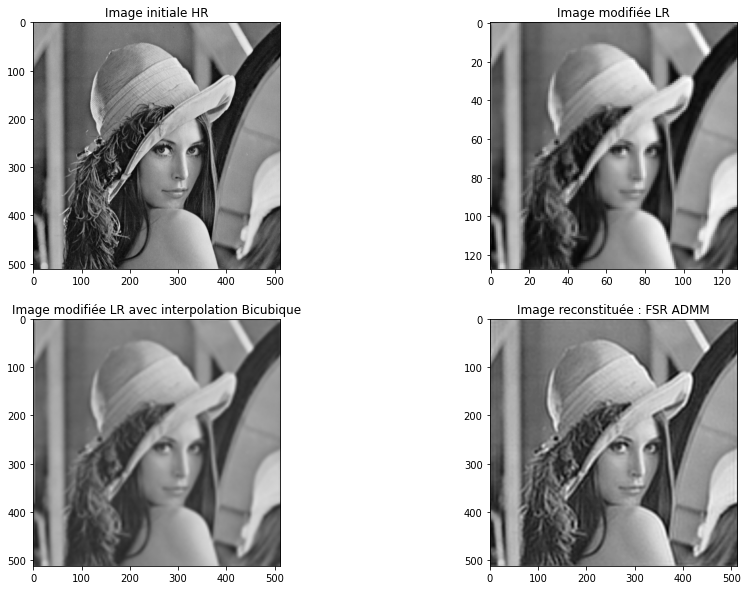

In [11]:
imageHR = plt.imread('images/lena.bmp')

tolA = 1e-3
muSet = [0.05]
t0 = timeit.timeit()
images_args, init_args, H_args, Dh_Dv_args, SH_y_args, FSR_args = init_params(imageHR, muSet)
imageLR_resized, imageLR = images_args
t1 = timeit.timeit()
FSR_image, _, _, _, _ = FSR_ADMM(imageHR, imageLR_resized, imageLR, tolA, init_args, H_args, Dh_Dv_args, SH_y_args, FSR_args)
t2 = timeit.timeit()
plot_images(FSR_image, imageHR, imageLR_resized, imageLR, 'FSR ADMM')

FSR_unique_time = t2-t1
print("Initialisation time", t1-t0)
print("Execution time of direct_ADMM", t2-t1)

In [12]:
%%time
FSR_image = FSR_ADMM(imageHR, imageLR_resized, imageLR, tolA, init_args, H_args, Dh_Dv_args, SH_y_args, FSR_args)

FSR ADMM: mu =  0.05 , Iter =  8 , RMSE =  6363.32631977519 , PSNR =  -28.067274940651732 , ISNR =  1.91949029825677e-06
CPU times: user 2.39 s, sys: 967 ms, total: 3.36 s
Wall time: 2.48 s


## Comparison

In this section we will choose the best value of mu for each algorithms, by trying to reduce the value of ISNR.  
  
Then, once we have optimal values, we will compare the results we obtained with the 3 methods by:
- comparing the error (ISNR)
- comparing the runtime
- comparing the rendered images


#### Finding optimal $\mu$ for ADMM and FSR_ADMM

In [13]:
# Find the optimal mu for direct_ADMM

imageHR = plt.imread('images/lena.bmp')

tolA = 1e-3
muSet = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
images_args, init_args, H_args, Dh_Dv_args, SH_y_args, _ = init_params(imageHR, muSet)
imageLR_resized, imageLR = images_args
direct_image, direct_ISNR, direct_RMSE, direct_PSNR, direct_Iter = direct_ADMM(imageHR, imageLR_resized, imageLR, tolA, init_args, H_args, Dh_Dv_args, SH_y_args)

direct ADMM: mu =  0.001 , Iter =  75 , RMSE =  4361.637527106129 , PSNR =  -25.009669728674204 , ISNR =  4.085499158953275e-06
direct ADMM: mu =  0.005 , Iter =  83 , RMSE =  4238.227593947734 , PSNR =  -24.760363807310227 , ISNR =  4.326888635492368e-06
direct ADMM: mu =  0.01 , Iter =  97 , RMSE =  4261.779167551687 , PSNR =  -24.808497155521856 , ISNR =  4.279198008256628e-06
direct ADMM: mu =  0.05 , Iter =  47 , RMSE =  4588.528355114711 , PSNR =  -25.393645013925923 , ISNR =  3.6914537150074404e-06
direct ADMM: mu =  0.1 , Iter =  36 , RMSE =  4698.452367544615 , PSNR =  -25.651253279201242 , ISNR =  3.5207453167966337e-06
direct ADMM: mu =  0.5 , Iter =  250 , RMSE =  4579.871650428057 , PSNR =  -25.42683055465233 , ISNR =  3.705421803188955e-06
direct ADMM: mu =  1 , Iter =  362 , RMSE =  4642.000326069702 , PSNR =  -25.550781645233428 , ISNR =  3.606898604286161e-06


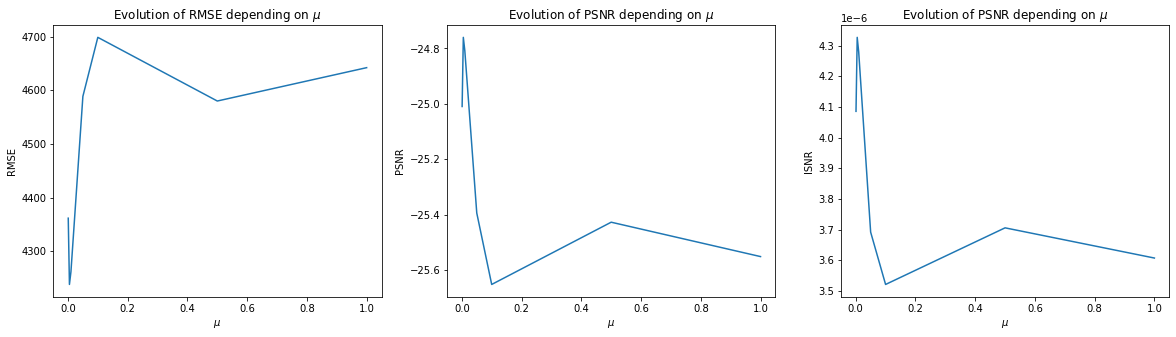

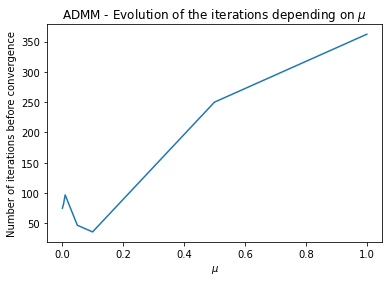

In [14]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(muSet, direct_RMSE)
plt.xlabel("$\mu$")
plt.ylabel("RMSE")
plt.title("Evolution of RMSE depending on $\mu$")

plt.subplot(1, 3, 2)
plt.plot(muSet, direct_PSNR)
plt.xlabel("$\mu$")
plt.ylabel("PSNR")
plt.title("Evolution of PSNR depending on $\mu$")

plt.subplot(1, 3, 3)
plt.plot(muSet, direct_ISNR)
plt.xlabel("$\mu$")
plt.ylabel("ISNR")
plt.title("Evolution of PSNR depending on $\mu$")
plt.show()

plt.plot(muSet, direct_Iter)
plt.xlabel("$\mu$")
plt.ylabel("Number of iterations before convergence")
plt.title("ADMM - Evolution of the iterations depending on $\mu$")
plt.show()

In [15]:
best_mu_direct = muSet[np.argmin(direct_RMSE)]
print("Optimal mu for direct_ADMM :", best_mu_direct)

Optimal mu for direct_ADMM : 0.005


In [16]:
# Find the optimal mu for FSR_ADMM

imageHR = plt.imread('images/lena.bmp')

tolA = 1e-3
muSet = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
images_args, init_args, H_args, Dh_Dv_args, SH_y_args, FSR_args = init_params(imageHR, muSet)
imageLR_resized, imageLR = images_args
FSR_image, FSR_ISNR, FSR_RMSE, FSR_PSNR, FSR_Iter = FSR_ADMM(imageHR, imageLR_resized, imageLR, tolA, init_args, H_args, Dh_Dv_args, SH_y_args, FSR_args)


FSR ADMM: mu =  0.001 , Iter =  1 , RMSE =  4788400.971437405 , PSNR =  -85.82048851745279 , ISNR =  3.389818227663589e-12
FSR ADMM: mu =  0.005 , Iter =  1 , RMSE =  1008501.5318642461 , PSNR =  -72.29020955713439 , ISNR =  7.641952020509088e-11
FSR ADMM: mu =  0.01 , Iter =  1 , RMSE =  536024.0345745516 , PSNR =  -66.80036357854551 , ISNR =  2.7051347573439323e-10
FSR ADMM: mu =  0.05 , Iter =  1 , RMSE =  158112.62918226307 , PSNR =  -56.19600952098218 , ISNR =  3.1090256873997143e-09
FSR ADMM: mu =  0.1 , Iter =  2 , RMSE =  110915.51667805173 , PSNR =  -53.116524445118344 , ISNR =  6.317901022428148e-09
FSR ADMM: mu =  0.5 , Iter =  8 , RMSE =  24927.551502656697 , PSNR =  -40.15027075714671 , ISNR =  1.2508297057170214e-07
FSR ADMM: mu =  1 , Iter =  38 , RMSE =  7426.923152835571 , PSNR =  -29.3868936312888 , ISNR =  1.4090927182766554e-06


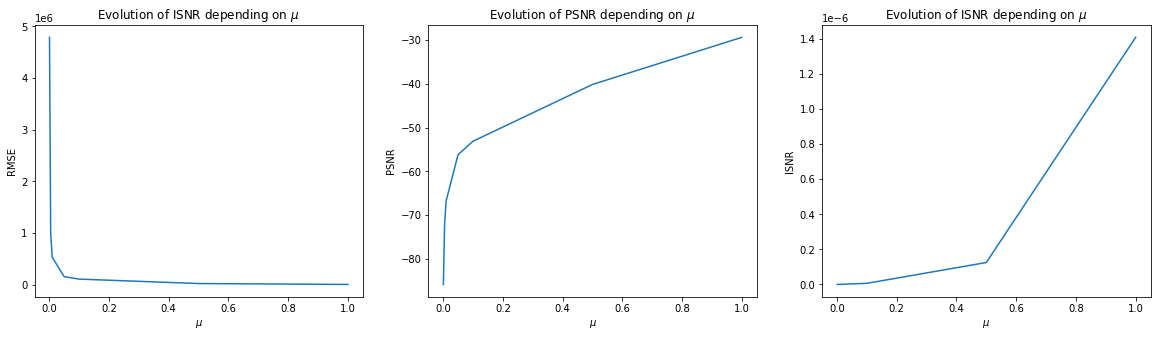

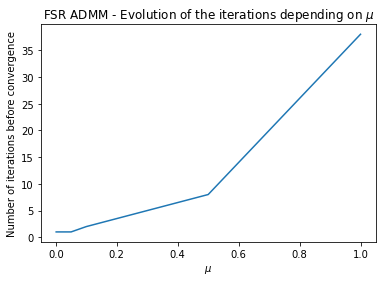

In [17]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(muSet, FSR_RMSE)
plt.xlabel("$\mu$")
plt.ylabel("RMSE")
plt.title("Evolution of ISNR depending on $\mu$")

plt.subplot(1, 3, 2)
plt.plot(muSet, FSR_PSNR)
plt.xlabel("$\mu$")
plt.ylabel("PSNR")
plt.title("Evolution of PSNR depending on $\mu$")

plt.subplot(1, 3, 3)
plt.plot(muSet, FSR_ISNR)
plt.xlabel("$\mu$")
plt.ylabel("ISNR")
plt.title("Evolution of ISNR depending on $\mu$")
plt.show()

plt.plot(muSet, FSR_Iter)
plt.xlabel("$\mu$")
plt.ylabel("Number of iterations before convergence")
plt.title("FSR ADMM - Evolution of the iterations depending on $\mu$")
plt.show()

In [18]:
best_mu_FSR = muSet[np.argmin(FSR_RMSE)]
print("Optimal mu for FSR_ADMM :", best_mu_FSR)

Optimal mu for FSR_ADMM : 1


For both algorithms, we compute the optimal $\mu$ based on the minimum of the RMSE metric. For FSR_ADMM, its gives an optimal value around 0.6, whereas for direct_ADMM it is 0.01.

In both algorithms, the average errors have the same order of magnitude, no matter the chosen metric between ISNR and PSNR ($\sim 1e^{-6}$ for ISNR, $\sim -1e^{-2}$ for PSRN), but FSR generally performs a little bit better. By computing the RSME, we see that FSR performs a lot better (ratio of $\sim 1e^{3}$)

We can also compare the number of iterations necessary to achieve convergence in both algorithms: in average, FSR_ADMM has a number of iteration between 0 and 50, whereas direct_ADMM is almost always above 100. This illustrates the goal of the article, to provide an algorithm that converges faster.

#### Comparing runtimes

In [19]:
%%time
L2_image, _, _ = L2_SR(imageHR)

CPU times: user 183 ms, sys: 106 ms, total: 288 ms
Wall time: 201 ms


In [20]:
muSet = [best_mu_direct] # chosing best mu
images_args, init_args, H_args, Dh_Dv_args, SH_y_args, FSR_args = init_params(imageHR, muSet)
imageLR_resized, imageLR = images_args

In [21]:
%%time
direct_image, _, _, _, _ = direct_ADMM(imageHR, imageLR_resized, imageLR, tolA, init_args, H_args, Dh_Dv_args, SH_y_args)

direct ADMM: mu =  0.005 , Iter =  83 , RMSE =  4243.834142445889 , PSNR =  -24.7718463619322 , ISNR =  4.3155114841824e-06
CPU times: user 18.4 s, sys: 7.6 s, total: 26 s
Wall time: 19.1 s


In [22]:
muSet = [best_mu_FSR] # chosing best mu
images_args, init_args, H_args, Dh_Dv_args, SH_y_args, FSR_args = init_params(imageHR, muSet)

In [23]:
%%time
FSR_image, _, _, _, _ = FSR_ADMM(imageHR, imageLR_resized, imageLR, tolA, init_args, H_args, Dh_Dv_args, SH_y_args, FSR_args)

FSR ADMM: mu =  1 , Iter =  24 , RMSE =  10547.883604318193 , PSNR =  -32.211945991308376 , ISNR =  6.985836615467804e-07
CPU times: user 7.58 s, sys: 2.26 s, total: 9.84 s
Wall time: 7.78 s


We notice that FSR_ADMM is almost 10 times faster than direct_ADMM with these parameters. With similar results (in terms of error between the HR image and the reconstructed image) for both algorithms, it illustrates clearly the purpose of the article.

#### Visual comparison of the rendered images

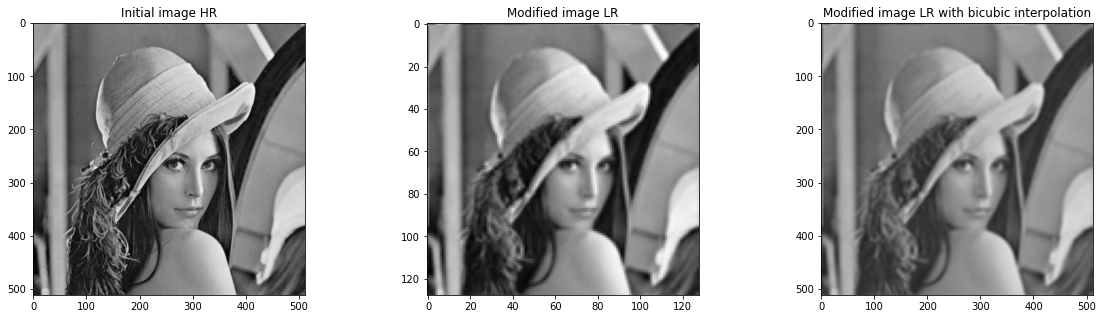

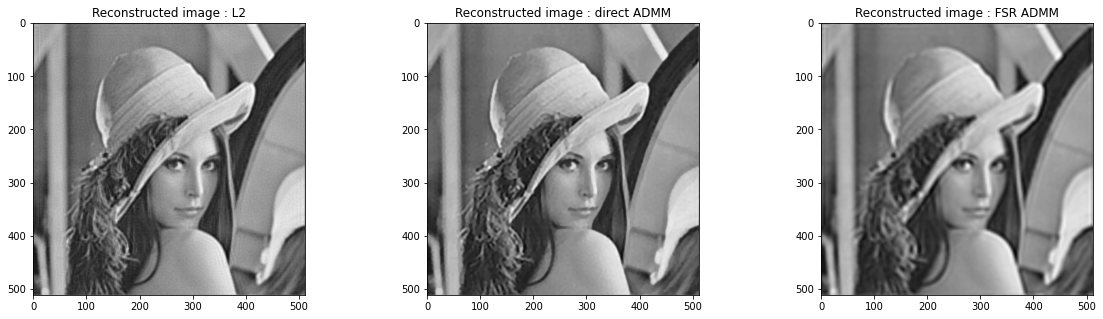

In [24]:
# Comparison rendered images

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(imageHR, cmap='gray')
plt.title('Initial image HR')

plt.subplot(1, 3, 2)
plt.imshow(imageLR, cmap='gray')
plt.title('Modified image LR')

plt.subplot(1, 3, 3)
plt.imshow(imageLR_resized, cmap='gray')
plt.title('Modified image LR with bicubic interpolation')
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.imshow(L2_image, cmap='gray')
plt.title('Reconstructed image : L2')

plt.subplot(1, 3, 2)
plt.imshow(np.real(direct_image), cmap='gray')
plt.title('Reconstructed image : direct ADMM')

plt.subplot(1, 3, 3)
plt.imshow(np.real(FSR_image), cmap='gray')
plt.title('Reconstructed image : FSR ADMM')
plt.show()

Visually, the rendered image for the FSR algorithm seems to be blurrier than with L2 and ADMM. However, we saw before that the errors had the same order of magnitude, so we can maybe consider that this is only a visual effect.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=338926a7-b34b-42e4-9d84-f4b70a5b3470' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>